# ChoiEtAl2021-BachelierModel

### Title: 
__A Black-Scholes user's guide to the Bachelier model__

### Authors:
* Jaehyuk Choi ([@jaehyukchoi](https://github.com/jaehyukchoi))
* Minsuk Kwak
* Chyng Wen Tee ([@cwtee](https://github.com/cwtee))
* Yumeng Wang ([@yumengwang123](https://github.com/yumengwang123))

### Abstract:
To cope with the negative oil futures price caused by the COVID-19 recession, global commodity futures exchanges switched the option model from Black-Scholes to Bachelier in April 2020. This study reviews the literature on Bachelier's pioneering option pricing model and summarizes the practical results on volatility conversion, risk management, stochastic volatility, and barrier options pricing to facilitate the model transition. In particular, using the displaced Black-Scholes model as a model family with the Black-Scholes and Bachelier models as special cases, we not only connect the two models but also present a continuous spectrum of model choices.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
import scipy as sp

### Uncomment below if you want to run on your modified code
#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/PyFENG')
import pyfeng as pf

# Implied BS volatility Skew (Fig. 1)

In [3]:
texp = 1
fwd = 1
k = np.arange(0.3, 2.01, 0.05)
strike = k*fwd

In [4]:
sigma = 0.5
norm = pf.Norm(sigma)
dbs1 = pf.BsmDisp(sigma, beta=1/3, pivot=fwd)
dbs2 = pf.BsmDisp(sigma, beta=2/3, pivot=fwd)
p = norm.price(strike, fwd, texp)

In [5]:
ivbs_0 = norm.vol_smile(strike, fwd, texp, model='bsm-approx')
ivbs_1 = dbs1.vol_smile(strike, fwd, texp, model='bsm-approx')
ivbs_2 = dbs2.vol_smile(strike, fwd, texp, model='bsm-approx')
ivbs = 0.5*np.ones_like(strike)

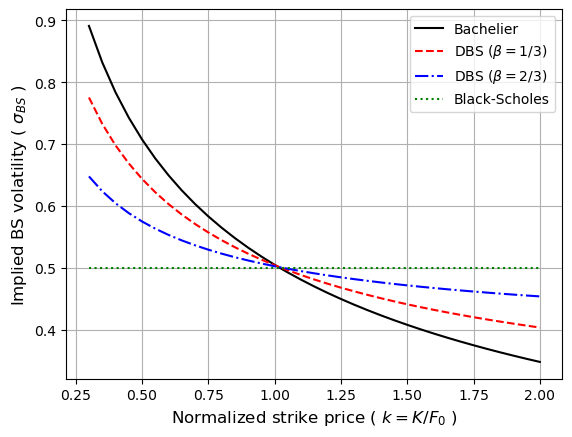

In [6]:
labels = ['Bachelier', 'DBS ($\\beta=1/3$)', 'DBS ($\\beta=2/3$)', 'Black-Scholes']
ls = ['-', '--', '-.', ':']
colors = ['k', 'r', 'b', 'g']

iv_arr = np.array([ivbs_0, ivbs_1, ivbs_2, ivbs])

for j in np.arange(len(iv_arr)):
    plt.plot(k, iv_arr[j], color=colors[j], linestyle=ls[j], label=labels[j])

plt.xlabel('Normalized strike price ( $k = K/F_0$ )', fontsize=12)
plt.ylabel('Implied BS volatility ( $\\sigma_{BS}$ )', fontsize=12)
plt.legend()
plt.grid()
#plt.savefig('iv-bs-skew.pdf', bbox_inches='tight')
#plt.savefig('iv-bs-skew.png', bbox_inches='tight')
plt.show()

# Equivalent Bachelier Volatility (Fig. 2)

In [7]:
texp = 1
fwd = 1
k = np.arange(0.1, 1.5, 0.05)
strike = k*fwd

In [8]:
sigma = 2
bsm = pf.Bsm(sigma)
norm = pf.Norm(sigma)
p = bsm.price(strike, fwd, texp)

In [9]:
ivn_0 = bsm.vol_smile(strike, fwd, texp, model='norm')
assert np.max( np.fabs(pf.Norm(ivn_0).price(strike, fwd, texp) - p) ) < 1e-10
ivn_1 = bsm.vol_smile(strike, fwd, texp, model='norm-grunspan')
ivn_2 = bsm.vol_smile(strike, fwd, texp, model='norm-approx')

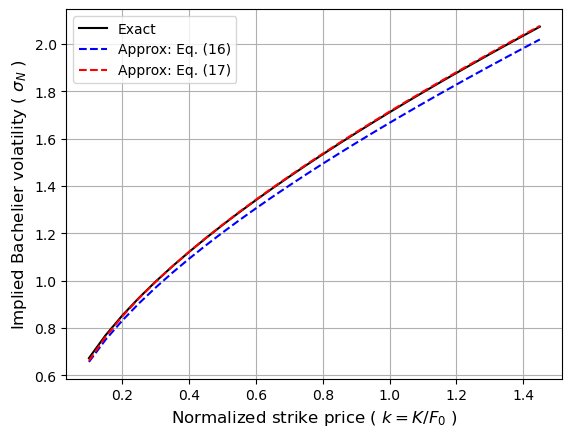

In [10]:
labels = ['Exact', 'Approx: Eq. (16)', 'Approx: Eq. (17)']
ls = ['-', '--', '--']
colors = ['k', 'b', 'r']

iv_arr = np.array([ivn_0, ivn_1, ivn_2])

for j in np.arange(len(iv_arr)):
    plt.plot(strike, iv_arr[j], color=colors[j], linestyle=ls[j], label=labels[j])

plt.xlabel('Normalized strike price ( $k = K/F_0$ )', fontsize=12)
plt.ylabel('Implied Bachelier volatility ( $\\sigma_{N}$ )', fontsize=12)
plt.legend()
plt.grid()
#plt.savefig('iv-bs2norm.pdf', bbox_inches='tight')
#plt.savefig('iv-bs2norm.png', bbox_inches='tight')
plt.show()

# Delta (Fig. 3)

In [11]:
texp = 1
fwd = 1
k = np.arange(0.7, 1.31, 0.05)
strike = k*fwd
sigma = 0.5
bs = pf.Bsm(sigma)
p = bs.price(strike, fwd, texp)
d_bs = bs.delta(strike, fwd, texp=1)

In [12]:
norm = pf.Norm(sigma)
dbs1 = pf.BsmDisp(sigma, beta=1/3,pivot=fwd)
dbs2 = pf.BsmDisp(sigma, beta=2/3,pivot=fwd)

In [13]:
norm.impvol(p, strike, fwd, texp, setval=True)
assert(np.max(np.abs(norm.price(strike, fwd, texp) - p))<1e-12)
d_norm = norm.delta(strike, fwd, texp)

dbs1.impvol(p, strike, fwd, texp, setval=True)
assert(np.max(np.abs(dbs1.price(strike, fwd, texp) - p))<1e-12)
d_dbs1 = dbs1.delta(strike, fwd, texp)

dbs2.impvol(p, strike, fwd, texp, setval=True)
assert(np.max(np.abs(dbs2.price(strike, fwd, texp) - p))<1e-12)
d_dbs2 = dbs2.delta(strike, fwd, texp)

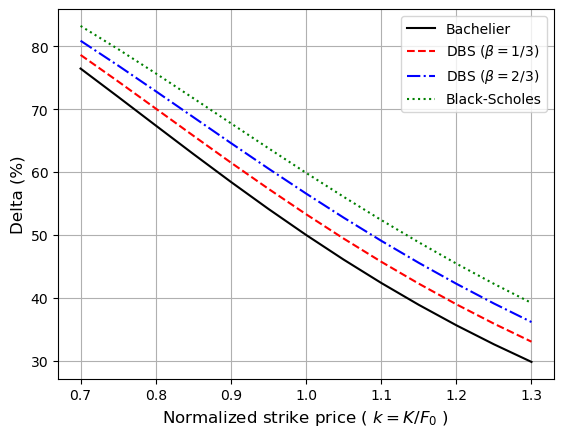

In [14]:
labels = ['Bachelier', 'DBS ($\\beta=1/3$)', 
          'DBS ($\\beta=2/3$)', 'Black-Scholes']
ls = ['-', '--', '-.', ':']
colors = ['k', 'r', 'b', 'g']

iv_arr = np.array([d_norm, d_dbs1, d_dbs2, d_bs])*100

for j in np.arange(len(iv_arr)):
    plt.plot(k, iv_arr[j], color=colors[j], linestyle=ls[j], label=labels[j])

plt.xlabel('Normalized strike price ( $k = K/F_0$ )', fontsize=12)
plt.ylabel('Delta (%)', fontsize=12)
plt.legend()
plt.grid()
#plt.savefig('delta.pdf', bbox_inches='tight')
#plt.savefig('delta.png', bbox_inches='tight')
plt.show()

# Backbone (Fig. 4)

In [15]:
texp = 1
fwd = 1
k = np.arange(0.7, 1.21, 0.05)
strike = k*fwd
sigma = 0.5
bs = pf.Bsm(sigma)
norm = pf.Norm(sigma)

In [16]:
iv1 = norm.vol_smile(strike, fwd, texp)
iv2 = norm.vol_smile(strike, fwd-0.1, texp)

In [17]:
fwd2 = fwd + np.arange(-0.16, 0.07, 0.025)
iv_atm = norm.vol_smile(fwd2, fwd2, texp)
iv_atm

array([0.60430882, 0.5863261 , 0.56939704, 0.55343052, 0.53834573,
       0.52407079, 0.51054147, 0.49770027, 0.48549547, 0.47388047])

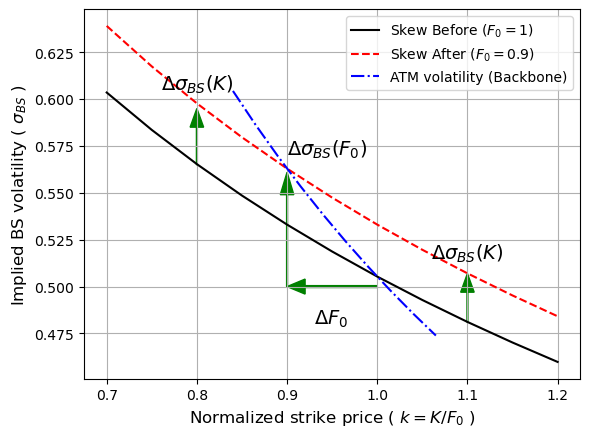

In [18]:
labels = ['Skew Before ($F_0=1$)', 'Skew After ($F_0=0.9$)', 'ATM volatility (Backbone)']
ls = ['-', '--', '-.', ':']
colors = ['k', 'r', 'b', 'g']

iv_arr = [iv1, iv2, iv_atm]

for j in np.arange(len(iv_arr)-1):
    plt.plot(k, iv_arr[j], color=colors[j], linestyle=ls[j], label=labels[j])

plt.plot(fwd2, iv_arr[j+1], color=colors[j+1], linestyle=ls[j+1], label=labels[j+1])

plt.xlabel('Normalized strike price ( $k = K/F_0$ )', fontsize=12)
plt.ylabel('Implied BS volatility ( $\\sigma_{BS}$ )', fontsize=12)
plt.arrow(1, 0.5, -0.08, 0, head_width=0.008, head_length=0.02, color='green')
plt.text(0.93, 0.48, '$\Delta F_0$', fontsize=14)
plt.arrow(0.9, 0.5, 0, 0.049, head_width=0.015, head_length=0.012, color='green')
plt.text(0.9, 0.57, '$\Delta \sigma_{BS}(F_0)$', fontsize=14)

plt.grid()
plt.arrow(0.8, 0.565, 0, 0.02, head_width=0.015, head_length=0.01, color='green')
plt.text(0.76, 0.605, '$\Delta \sigma_{BS}(K)$', fontsize=14)
plt.arrow(1.1, 0.481, 0, 0.016, head_width=0.015, head_length=0.01, color='green')
plt.text(1.06, 0.515, '$\Delta \sigma_{BS}(K)$', fontsize=14)
plt.legend()
#plt.savefig('backbone.pdf', bbox_inches='tight')
#plt.savefig('backbone.png', bbox_inches='tight')
plt.show()

# NSVh Smile (Fig. 5)

In [19]:
texp = 1
fwd = 100
k = np.arange(0.6, 1.401, 0.02)
strike = k*fwd
sigma = 20
norm = pf.Norm(sigma)

## Upper: Changing vol-of-vol ($\nu$)
Run only one of the below

In [20]:
model_name = 'NSVh Model'
file_name = 'nsvh-vov'

vov_arr = np.array([0.1, 0.2, 0.3])[:, None]

nsvh = pf.Nsvh1(sigma, vov=vov_arr, rho=0.1, is_atmvol=True)
iv_arr = nsvh.vol_smile(strike, fwd, texp)

In [21]:
"""
model_name = 'SABR Model ($\\beta=0$)'
file_name = 'sabr0-vov'

vov_arr = np.array([0.1, 0.2, 0.3])[:, None]

sabr = pf.SabrNorm(sigma, vov=vov_arr, rho=0.1, is_atmvol=True)
iv_arr = sabr.vol_for_price(strike, fwd, texp)
"""

"\nmodel_name = 'SABR Model ($\\beta=0$)'\nfile_name = 'sabr0-vov'\n\nvov_arr = np.array([0.1, 0.2, 0.3])[:, None]\n\nsabr = pf.SabrNorm(sigma, vov=vov_arr, rho=0.1, is_atmvol=True)\niv_arr = sabr.vol_for_price(strike, fwd, texp)\n"

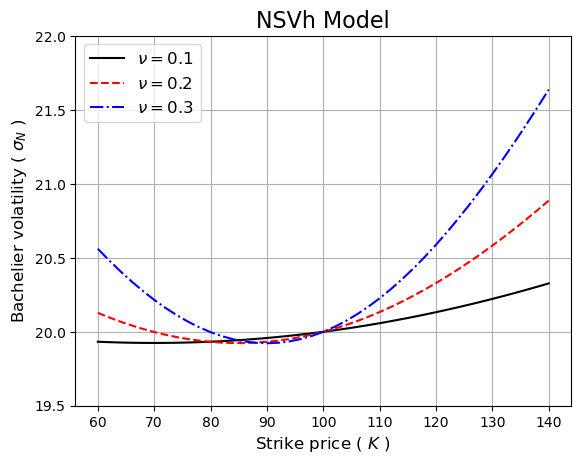

In [22]:
labels = ['$\\nu=0.1$', '$\\nu=0.2$', '$\\nu=0.3$']
ls = ['-', '--', '-.']
colors = ['k', 'r', 'b']

for j in np.arange(len(iv_arr)):
    plt.plot(strike, iv_arr[j], color=colors[j], linestyle=ls[j], label=labels[j])

plt.xlabel('Strike price ( $K$ )', fontsize=12)
plt.ylabel('Bachelier volatility ( $\\sigma_{N}$ )', fontsize=12)
plt.title(model_name, fontsize=16)

plt.legend(fontsize=12)
plt.ylim([19.5, 22])
plt.grid()
#plt.savefig(f'{file_name}.pdf', bbox_inches='tight')
#plt.savefig(f'{file_name}.png', bbox_inches='tight')
plt.show()

## Lower: Changing vol-of-vol ($\rho$)
Run only one of the below

In [23]:
model_name = 'NSVh Model'
file_name = 'nsvh-rho'

rho_arr = np.array([-0.1, 0.1, 0.3])[:, None]

nsvh = pf.Nsvh1(sigma, vov=0.2, rho=rho_arr, is_atmvol=True)
iv_arr = nsvh.vol_smile(strike, fwd, texp)

In [24]:
"""
model_name = 'SABR Model ($\\beta=0$)'
file_name = 'sabr0-rho'

rho_arr = np.array([-0.1, 0.1, 0.3])[:, None]

sabr = pf.SabrNorm(sigma, vov=0.2, rho=rho_arr, is_atmvol=True)
iv_arr = sabr.vol_for_price(strike, fwd, texp)
"""

"\nmodel_name = 'SABR Model ($\\beta=0$)'\nfile_name = 'sabr0-rho'\n\nrho_arr = np.array([-0.1, 0.1, 0.3])[:, None]\n\nsabr = pf.SabrNorm(sigma, vov=0.2, rho=rho_arr, is_atmvol=True)\niv_arr = sabr.vol_for_price(strike, fwd, texp)\n"

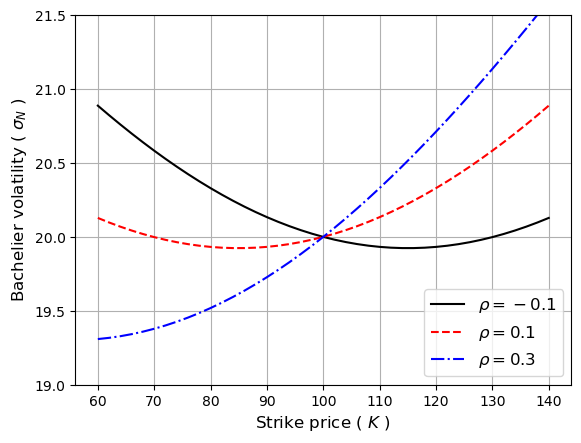

In [25]:
labels = ['$\\rho=-0.1$', '$\\rho=0.1$', '$\\rho=0.3$']
ls = ['-', '--', '-.']
colors = ['k', 'r', 'b']

for j in np.arange(len(iv_arr)):
    plt.plot(strike, iv_arr[j], color=colors[j], linestyle=ls[j], label=labels[j])

plt.xlabel('Strike price ( $K$ )', fontsize=12)
plt.ylabel('Bachelier volatility ( $\\sigma_{N}$ )', fontsize=12)
#plt.title(model_name, fontsize=16)

plt.legend(fontsize=12)
plt.ylim([19, 21.5])
plt.grid()
#plt.savefig(f'{file_name}.pdf', bbox_inches='tight')
#plt.savefig(f'{file_name}.png', bbox_inches='tight')
plt.show()

# Barrier Option (Fig. 6)

In [26]:
texp = 1
fwd = 1
strike = 1
barrier_dn = np.arange(0.1, 0.971, 0.025)
barrier = np.array([barrier_dn, 1 +1.5* (1-barrier_dn[::-1])])
cp = np.array([[-1], [1]])
sigma = 0.5
bs = pf.Bsm(sigma)
p = 0.2
bs.impvol(p, strike, fwd, texp, setval=True)

0.5066942062715994

In [27]:
norm = pf.Norm(sigma)
norm.impvol(p, strike, fwd, texp, setval=True)
bar1 = pf.BsmDisp(sigma, beta=1/3, pivot=fwd)
bar1.impvol(p, strike, fwd, texp, setval=True)
bar2 = pf.BsmDisp(sigma, beta=2/3, pivot=fwd)
bar2.impvol(p, strike, fwd, texp, setval=True)
bar3 = pf.BsmDisp(sigma, beta=1, pivot=fwd)
bar3.impvol(p, strike, fwd, texp, setval=True)

0.5066942062715994

In [28]:
p0dn = norm.price_barrier(strike, barrier, fwd, texp, cp=cp)
p1dn = bar1.price_barrier(strike, barrier, fwd, texp, cp=cp)
p2dn = bar2.price_barrier(strike, barrier, fwd, texp, cp=cp)
p3dn = bar3.price_barrier(strike, barrier, fwd, texp, cp=cp)

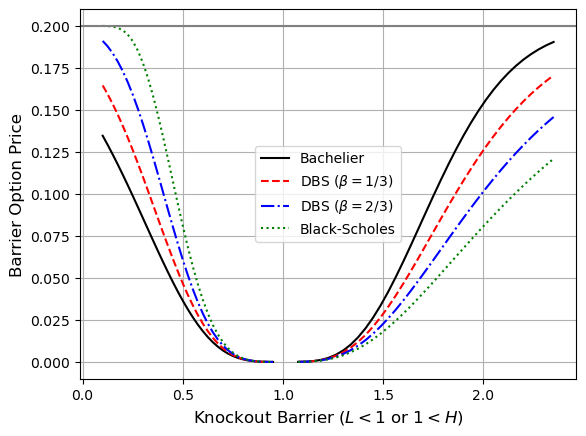

In [29]:
labels = ['Bachelier', 'DBS ($\\beta=1/3$)', 
          'DBS ($\\beta=2/3$)', 'Black-Scholes']
ls = ['-', '--', '-.', ':']
colors = ['k', 'r', 'b', 'g']

iv_arr = np.array([p0dn, p1dn, p2dn, p3dn])
for j in np.arange(len(iv_arr)):
    plt.plot(barrier[0], iv_arr[j][0], color=colors[j], linestyle=ls[j], label=labels[j])
    plt.plot(barrier[1], iv_arr[j][1], color=colors[j], linestyle=ls[j])

plt.axhline(y=p, color='gray', linestyle='-')
#for j in np.arange(len(iv_arr)):

plt.xlabel('Knockout Barrier ($L<1$ or $1<H$)', fontsize=12)
plt.ylabel('Barrier Option Price', fontsize=12)
plt.legend()
plt.grid()
#plt.savefig('barrier.pdf', bbox_inches='tight')
#plt.savefig('barrier.png', bbox_inches='tight')
plt.show()